# 🎉 Out-of-Distribution (OOD) with PCA using Deep Features from the Latent Space

The goal of this notebook is to understand the depths of using Principal Component Analysis in order to perform OOD tasks using deep features from the latent space

## 📝 Plan of action

### ♻️ Preprocessing phase

In order to achieve our goal, we need to understand how the dataset is structured.

For this notebook, we are going to use the CBIR 15 dataset, that contains images of different places, such as an office, a bedroom, a mountain, etc. Note that there are some places that are similar one to another, i.e. a bedroom and a living room.

Thus, in order to extract the features of the images we have to preprocess those images:

- Get the images that are located in data/CBIR_15-scene and fit them to a dataframe using Pandas
  - Locate the "Labels.txt" file: it shows where the indexes of the images from each category starts
- Create the dataset with this information with two columns: the path to the image and its category
- Transform all of the images in the same size (in this case, we are going with 256x256)
  
Now, in order to extract the features, it's necessary to divide the reshaped images into patches of 32x32 pixels. This is good to perform processing tasks to avoid waiting long periods of time.

After all the preprocess, we should separate the images into two different foldes: one contains the patches of the training images that is going to give us their principal components and dimensions, and the other is the patches of the test images, that is going to be tested to fit into those dimensions and we'll get an OOD score afterwards.

### 🏋🏽‍♂️ Training phase

With the images that are stored inside the "patches_train" folder, the first thing we are going to do is _normalize_ all of the images to find the correct maximum covariance and transforming all the variables into the same scale.

Next, we should then apply the PCA with all the components. As we have patches of 32x32, we'll be having 1024 features, hence components. Then we plot a graph to see how many components truly contributes for the most variance of the data - and give us more information about it. We're going to take the threshold of 95% of variance in this notebook.

After getting the PCA with components that describe 95% of the variance, it's time to test our images and see how far of the residual space their data can be found.

### ⚗️ Test phase and results

In this phase, we take the test images and normalize then with the same scale of each PCA. This is important to maintain consistency throughout the final results and measure the norms in the new dimension properly.

After that, we calculate the norm of the projection of the given data into the orthogonal space of the principal component and divide it by the norm of the data in relation to the origin. This is the OOD score.

We calculate the mean of the score for each category and get the minimal one. The current environment is the smallest.


--------------------------

First of all, we need to understand which libraries we are going to use:

- os: Deals with the operation system interface such as finding the relative and absolute path of files inside a project and reading/writing files for example.
- sys: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
- numpy: NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.
- pandas: Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- matplotlib: Deals with plotting graphs to visualize data in a graphical way.
- sklearn: Scikit-learn provides dozens of built-in machine learning algorithms and models, called estimators.

In [57]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


I'd suggest to use a conda virtual environment in order to avoid messing up your base kernel environment and causing dependency errors in the future.

After you successfully installed all the modules, it's time to import our custom modules that are going to deal with:

- Creation of our dataframe using pandas
- Separation of our dataset into patches of 32x32 in folders of training and test

In [58]:

sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
# from image_patching import *

In [59]:
standard_size = (256, 256)  # Tamanho padrão para redimensionar as imagens
input_size = (224, 224)     # Tamanho de entrada esperado pelo VGG16

def create_patches(image, patch_size):
    h, w, c = image.shape
    patches = []
    positions = []

    for i in range(0, h, patch_size[0]):
        for j in range(0, w, patch_size[1]):
            patch = np.zeros((patch_size[0], patch_size[1], c), dtype=image.dtype)
            patch_part = image[i:i + patch_size[0], j:j + patch_size[1]]
            patch[:patch_part.shape[0], :patch_part.shape[1]] = patch_part
            patches.append(patch)
            positions.append((i, j))
    return patches, positions

def save_patches(patches, positions, output_dir, prefix, original_shape, patch_size=(32, 32)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    shape_filename = os.path.join(output_dir, f"{prefix}_shape.txt")
    with open(shape_filename, 'w') as f:
        f.write(f"{original_shape[0]},{original_shape[1]},{original_shape[2]}\n")
        f.write(f"Number of Patches: {len(patches)}\n")
        f.write(f"Patch Size: {patch_size[0]},{patch_size[1]}\n")
    for idx, (patch, position) in enumerate(zip(patches, positions)):
        patch_filename = os.path.join(output_dir, f"{prefix}_patch_{position[0]}_{position[1]}.png")
        cv2.imwrite(patch_filename, patch)

def resize_image(image, size):
    return cv2.resize(image, size)

def create_images_set(X_train, X_test, y_train, y_test, patch_size=(32, 32), output_dir_train='patches_train', output_dir_test='patches_test', standard_size=(256, 256)):
    # Processar imagens de treino
    for path, category in zip(X_train, y_train):
        image = cv2.imread(path)
        if image is not None:
            idx = os.path.splitext(os.path.basename(path))[0]  # Usar o nome da imagem como índice
            resized_image = resize_image(image, standard_size)
            image_patches, positions = create_patches(resized_image, patch_size)
            category_dir = os.path.join(output_dir_train, str(category), f'image_{idx}')
            save_patches(image_patches, positions, category_dir, f'image_{idx}', resized_image.shape, patch_size)

    # Processar imagens de teste
    for path, category in zip(X_test, y_test):
        image = cv2.imread(path)
        if image is not None:
            idx = os.path.splitext(os.path.basename(path))[0]  # Usar o nome da imagem como índice
            resized_image = resize_image(image, standard_size)
            image_patches, positions = create_patches(resized_image, patch_size)
            category_dir = os.path.join(output_dir_test, str(category), f'image_{idx}')
            save_patches(image_patches, positions, category_dir, f'image_{idx}', resized_image.shape, patch_size)

def load_patches_by_category(base_dir, categories, patch_size=(244, 244)):
    patches_by_category = {}
    for category in categories:
        category_patches = []
        category_dir = os.path.join(base_dir, str(category))
        for root, _, files in os.walk(category_dir):
            for filename in files:
                if filename.endswith('.png'):
                    patch = cv2.imread(os.path.join(root, filename))
                    if patch is not None and patch.shape[:2] == patch_size:
                        category_patches.append(patch)
        patches_by_category[category] = np.array(category_patches)
    return patches_by_category

In [60]:
import tarfile

def extract_tgz(tgz_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)
        print(f"Arquivos extraídos para {extract_to}")

tgz_path = '../CBIR_15-Scene.tgz'
extract_to = '../data/'

extract_tgz(tgz_path, extract_to)

Arquivos extraídos para ../data/


In [61]:
df, split_variables = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
4480,../data/CBIR_15-Scene/14/4481.jpg,Store
4481,../data/CBIR_15-Scene/14/4482.jpg,Store
4482,../data/CBIR_15-Scene/14/4483.jpg,Store
4483,../data/CBIR_15-Scene/14/4484.jpg,Store


## ☝️ Part I: Comparing two different environments

### ♻️ Preprocessing phase

Now we start our experiments to understand if our idea work, however this time we are going to understand what happens with our approach using two different environments.

In our case, I'm going to take the **Coast** and **Office** environments arbitrarily.


In [62]:
train_categories = ['Coast', 'Office']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
1267,../data/CBIR_15-Scene/05/1268.jpg,Coast
1268,../data/CBIR_15-Scene/05/1269.jpg,Coast
1269,../data/CBIR_15-Scene/05/1270.jpg,Coast
1270,../data/CBIR_15-Scene/05/1271.jpg,Coast
1271,../data/CBIR_15-Scene/05/1272.jpg,Coast
...,...,...
4165,../data/CBIR_15-Scene/13/4166.jpg,Office
4166,../data/CBIR_15-Scene/13/4167.jpg,Office
4167,../data/CBIR_15-Scene/13/4168.jpg,Office
4168,../data/CBIR_15-Scene/13/4169.jpg,Office


It's time to separate our dataset into train and test. We should use the built-in function of sklearn to do this:

In [63]:
X = df_different['image_path']
y = df_different['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)

patch_size = (224, 224)


Making sure that everything went well, we plot the grid of all the patches from the first image of our training set

This is exactly what the module that's inside our "image_patching.py" do. So we now, need to save everything into the subfolders by calling that function:

In [64]:
create_images_set(X_train, X_test, y_train, y_test, patch_size, output_dir_train='patches_train', output_dir_test='patches_test')

Now, we should load our patches for training:

In [65]:
training_patches_by_category = load_patches_by_category('patches_train', y, patch_size)

### 🏋🏽‍♂️ Training phase

Now that the have our training patches stored in that variable above, we should start our analysis with PCA.

First of all, we **need to normalize and center** the data. It's so importantt that I had to emphasize it. Plus, since we are dealing with different categories, each one of them should be normalized with a different scaler (and we're going to save it for later).

In [66]:
def normalize_and_center_patches(patches, scaler=None):
    # Flatten patches to 2D array if not already flattened
    original_shape = patches.shape
    if len(original_shape) > 2:
        patches = patches.reshape((patches.shape[0], -1))
    
    if scaler is None:
        scaler = StandardScaler()
        standardized_patches = scaler.fit_transform(patches)
    else:
        standardized_patches = scaler.transform(patches)

    # Reshape back to original patch shape if needed
    if len(original_shape) > 2:
        standardized_patches = standardized_patches.reshape(original_shape)
        
    return standardized_patches, scaler

standardized_patches_by_category = {}
scalers_by_category = {}
for category, patches in training_patches_by_category.items():
    standardized_patches, scaler = normalize_and_center_patches(patches)
    standardized_patches_by_category[category] = standardized_patches
    scalers_by_category[category] = scaler


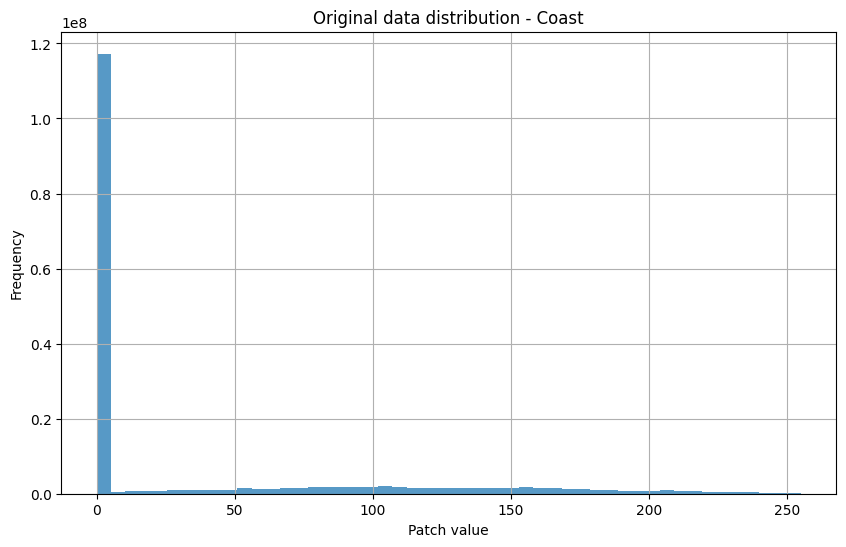

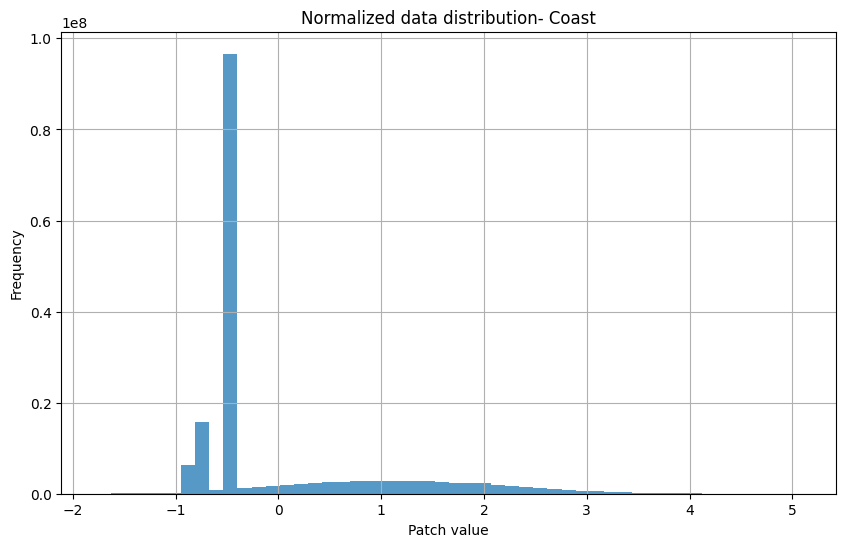

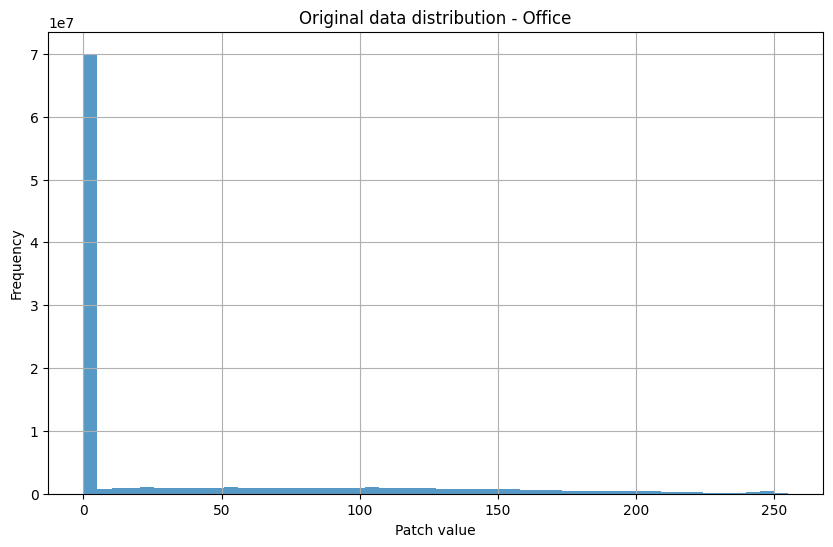

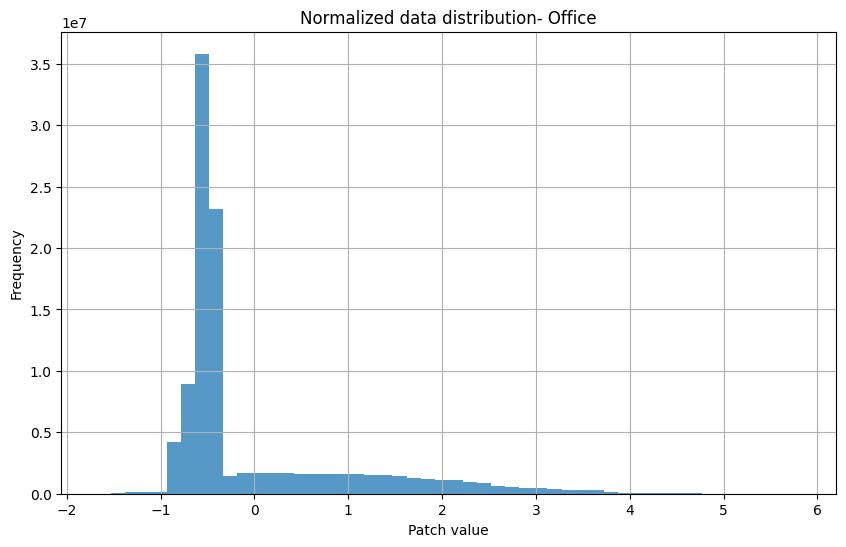

In [67]:
def plot_distribution(patches, title):
    plt.figure(figsize=(10, 6))
    plt.hist(patches.flatten(), bins=50, alpha=0.75)
    plt.title(title)
    plt.xlabel('Patch value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


for category, patches in training_patches_by_category.items():
    plot_distribution(patches, f'Original data distribution - {category}')
    plot_distribution(standardized_patches_by_category[category], f'Normalized data distribution- {category}')

In [68]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

In [69]:
preprocessed_patches_by_category = {}
for category, patches in standardized_patches_by_category.items():
    resized_patches = np.array([resize_image(patch, input_size) for patch in patches])
    preprocessed_patches = preprocess_input(resized_patches)
    preprocessed_patches_by_category[category] = preprocessed_patches

for category, patches in preprocessed_patches_by_category.items():
    print(f"Categoria {category}, forma dos patches: {patches.shape}")

Categoria Coast, forma dos patches: (1152, 224, 224, 3)
Categoria Office, forma dos patches: (688, 224, 224, 3)


In [70]:
base_model = VGG16(weights='imagenet', include_top=True)

In [71]:
# Getting the before last layer (Fully connected)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [72]:
# Extrair características usando o modelo VGG16
features_by_category = {}
for category, patches in preprocessed_patches_by_category.items():
    features = model.predict(patches)
    features_by_category[category] = features

# Verificar a forma das características extraídas
for category, features in features_by_category.items():
    print(f"Categoria {category}, forma das características: {features.shape}")

22/22 [==============================] - 53s 2s/step
Categoria Coast, forma das características: (1152, 4096)
Categoria Office, forma das características: (688, 4096)


In [73]:
from sklearn.decomposition import PCA

# Aplicar PCA para cada conjunto de características por categoria
pca_by_category = {}
explained_variance_by_category = {}

for category, features in features_by_category.items():
    pca = PCA(n_components=0.95)  # Manter 95% da variância
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    # Printando a quantidade de componentes após o PCA
    print(f"Categoria {category}, componentes principais: {principal_components.shape[1]}")

# Verificar a forma dos componentes principais extraídos
for category, pca in pca_by_category.items():
    print(f"Categoria {category}, forma dos componentes principais: {pca.components_.shape}")
    print(f"Categoria {category}, variância explicada: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")


Categoria Coast, componentes principais: 32
Categoria Office, componentes principais: 28
Categoria Coast, forma dos componentes principais: (32, 4096)
Categoria Coast, variância explicada: 95.16%
Categoria Office, forma dos componentes principais: (28, 4096)
Categoria Office, variância explicada: 95.17%


In [74]:
def load_and_preprocess_test_patches(test_dir, categories, patch_size, input_size):
    test_patches_by_category = load_patches_by_category(test_dir, categories, patch_size)
    test_standardized_patches_by_category = {}
    test_scalers_by_category = {}

    for category, patches in test_patches_by_category.items():
        test_standardized_patches, test_scaler = normalize_and_center_patches(patches)
        test_standardized_patches_by_category[category] = test_standardized_patches
        test_scalers_by_category[category] = test_scaler

    test_preprocessed_patches_by_category = {}
    for category, patches in test_standardized_patches_by_category.items():
        test_resized_patches = np.array([resize_image(patch, input_size) for patch in patches])
        test_preprocessed_patches = preprocess_input(test_resized_patches)
        test_preprocessed_patches_by_category[category] = test_preprocessed_patches

    return test_preprocessed_patches_by_category

# Exemplo de uso da função
test_preprocessed_patches_by_category = load_and_preprocess_test_patches('patches_test', y, patch_size, input_size)


In [75]:
def extract_features_with_vgg16(model, preprocessed_patches_by_category):
    features_by_category = {}
    for category, patches in preprocessed_patches_by_category.items():
        features = model.predict(patches)
        features_by_category[category] = features
    return features_by_category

# Exemplo de uso da função
test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_patches_by_category)


6/6 [==============================] - 13s 2s/step


In [76]:
def calculate_reconstruction_error(test_features, pca_by_category):
    mean_reconstruction_errors = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        
        # Reconstruir as características a partir dos componentes principais
        reconstructed_features = pca.inverse_transform(principal_components)
        
        # Calcular o erro de reconstrução (erro absoluto médio)
        reconstruction_error = np.mean(np.abs(test_features - reconstructed_features), axis=1)
        mean_reconstruction_errors[category] = np.mean(reconstruction_error)
    
    # Identificar a categoria com o menor erro médio de reconstrução
    best_category = min(mean_reconstruction_errors, key=mean_reconstruction_errors.get)

    for category in mean_reconstruction_errors:
        print(f"Categoria {category}, erro médio de reconstrução: {mean_reconstruction_errors[category]}")
    
    print(f"A categoria com o menor erro médio de reconstrução é: {best_category}")

    return mean_reconstruction_errors, best_category

# Exemplo de uso da função com dados de teste
for category, test_features in test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Coast
Categoria Coast, erro médio de reconstrução: 0.006329378113150597
Categoria Office, erro médio de reconstrução: 0.009358472190797329
A categoria com o menor erro médio de reconstrução é: Coast
Test category: Office
Categoria Coast, erro médio de reconstrução: 0.012230810709297657
Categoria Office, erro médio de reconstrução: 0.010172921232879162
A categoria com o menor erro médio de reconstrução é: Office


## ✌️ Part II: Comparing two similar environments

In [77]:
train_categories = ['Bedroom', 'LivingRoom']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
1262,../data/CBIR_15-Scene/04/1263.jpg,LivingRoom
1263,../data/CBIR_15-Scene/04/1264.jpg,LivingRoom
1264,../data/CBIR_15-Scene/04/1265.jpg,LivingRoom
1265,../data/CBIR_15-Scene/04/1266.jpg,LivingRoom


In [78]:
X = df_different['image_path']
y = df_different['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)

patch_size = (224, 224)


In [79]:
create_images_set(X_train, X_test, y_train, y_test, patch_size, output_dir_train='patches_train', output_dir_test='patches_test')

In [80]:
training_patches_by_category = load_patches_by_category('patches_train', y, patch_size)

In [81]:
def normalize_and_center_patches(patches, scaler=None):
    # Flatten patches to 2D array if not already flattened
    original_shape = patches.shape
    if len(original_shape) > 2:
        patches = patches.reshape((patches.shape[0], -1))
    
    if scaler is None:
        scaler = StandardScaler()
        standardized_patches = scaler.fit_transform(patches)
    else:
        standardized_patches = scaler.transform(patches)

    # Reshape back to original patch shape if needed
    if len(original_shape) > 2:
        standardized_patches = standardized_patches.reshape(original_shape)
        
    return standardized_patches, scaler

standardized_patches_by_category = {}
scalers_by_category = {}
for category, patches in training_patches_by_category.items():
    standardized_patches, scaler = normalize_and_center_patches(patches)
    standardized_patches_by_category[category] = standardized_patches
    scalers_by_category[category] = scaler


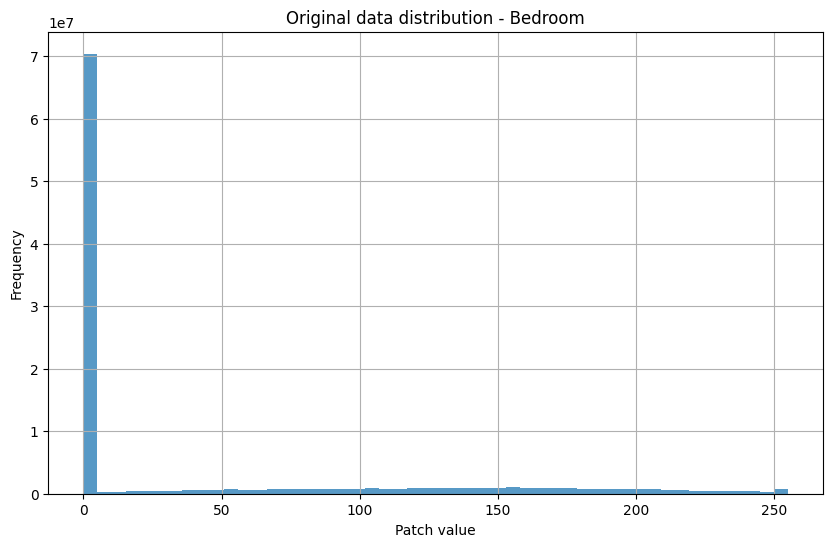

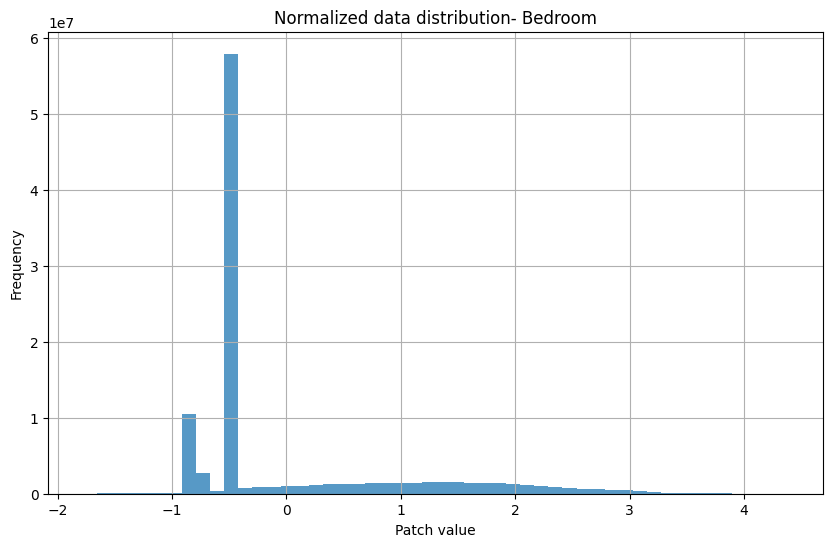

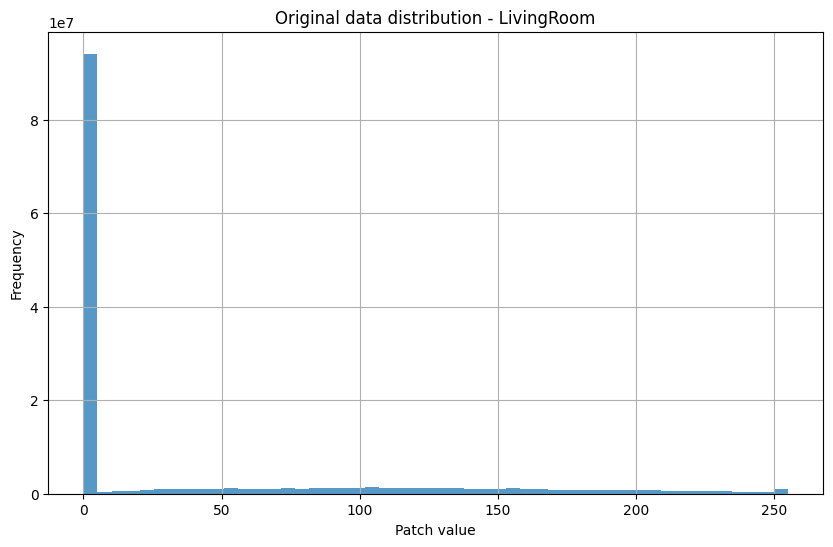

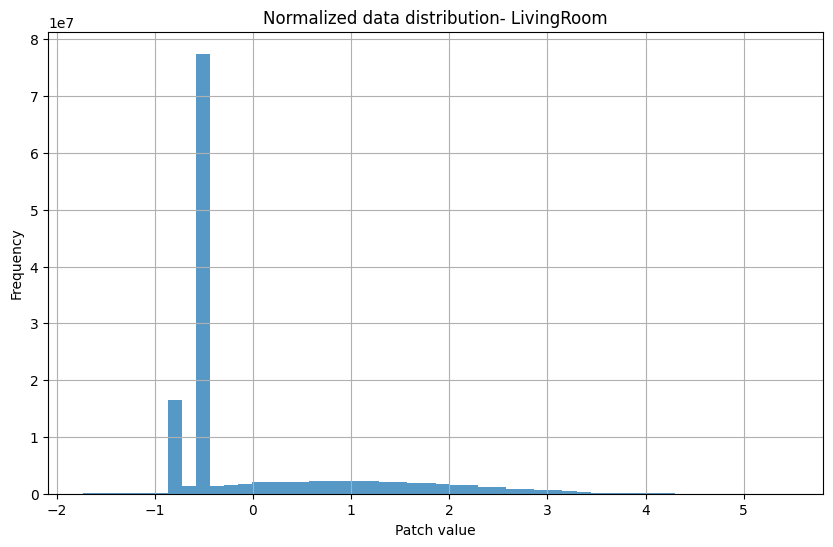

In [82]:
def plot_distribution(patches, title):
    plt.figure(figsize=(10, 6))
    plt.hist(patches.flatten(), bins=50, alpha=0.75)
    plt.title(title)
    plt.xlabel('Patch value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


for category, patches in training_patches_by_category.items():
    plot_distribution(patches, f'Original data distribution - {category}')
    plot_distribution(standardized_patches_by_category[category], f'Normalized data distribution- {category}')

In [83]:
preprocessed_patches_by_category = {}
for category, patches in standardized_patches_by_category.items():
    resized_patches = np.array([resize_image(patch, input_size) for patch in patches])
    preprocessed_patches = preprocess_input(resized_patches)
    preprocessed_patches_by_category[category] = preprocessed_patches

for category, patches in preprocessed_patches_by_category.items():
    print(f"Categoria {category}, forma dos patches: {patches.shape}")

Categoria Bedroom, forma dos patches: (692, 224, 224, 3)
Categoria LivingRoom, forma dos patches: (924, 224, 224, 3)


In [84]:
base_model = VGG16(weights='imagenet', include_top=True)

In [85]:
# Getting the before last layer (Fully connected)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [86]:
# Extrair características usando o modelo VGG16
features_by_category = {}
for category, patches in preprocessed_patches_by_category.items():
    features = model.predict(patches)
    features_by_category[category] = features

# Verificar a forma das características extraídas
for category, features in features_by_category.items():
    print(f"Categoria {category}, forma das características: {features.shape}")

29/29 [==============================] - 77s 3s/step
Categoria Bedroom, forma das características: (692, 4096)
Categoria LivingRoom, forma das características: (924, 4096)


In [87]:
from sklearn.decomposition import PCA

# Aplicar PCA para cada conjunto de características por categoria
pca_by_category = {}
explained_variance_by_category = {}

for category, features in features_by_category.items():
    pca = PCA(n_components=0.95)  # Manter 95% da variância
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    # Printando a quantidade de componentes após o PCA
    print(f"Categoria {category}, componentes principais: {principal_components.shape[1]}")

# Verificar a forma dos componentes principais extraídos
for category, pca in pca_by_category.items():
    print(f"Categoria {category}, forma dos componentes principais: {pca.components_.shape}")
    print(f"Categoria {category}, variância explicada: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")


Categoria Bedroom, componentes principais: 31
Categoria LivingRoom, componentes principais: 31
Categoria Bedroom, forma dos componentes principais: (31, 4096)
Categoria Bedroom, variância explicada: 95.12%
Categoria LivingRoom, forma dos componentes principais: (31, 4096)
Categoria LivingRoom, variância explicada: 95.06%


In [88]:
def load_and_preprocess_test_patches(test_dir, categories, patch_size, input_size):
    test_patches_by_category = load_patches_by_category(test_dir, categories, patch_size)
    test_standardized_patches_by_category = {}
    test_scalers_by_category = {}

    for category, patches in test_patches_by_category.items():
        test_standardized_patches, test_scaler = normalize_and_center_patches(patches)
        test_standardized_patches_by_category[category] = test_standardized_patches
        test_scalers_by_category[category] = test_scaler

    test_preprocessed_patches_by_category = {}
    for category, patches in test_standardized_patches_by_category.items():
        test_resized_patches = np.array([resize_image(patch, input_size) for patch in patches])
        test_preprocessed_patches = preprocess_input(test_resized_patches)
        test_preprocessed_patches_by_category[category] = test_preprocessed_patches

    return test_preprocessed_patches_by_category

# Exemplo de uso da função
test_preprocessed_patches_by_category = load_and_preprocess_test_patches('patches_test', y, patch_size, input_size)


In [89]:
def extract_features_with_vgg16(model, preprocessed_patches_by_category):
    features_by_category = {}
    for category, patches in preprocessed_patches_by_category.items():
        features = model.predict(patches)
        features_by_category[category] = features
    return features_by_category

# Exemplo de uso da função
test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_patches_by_category)


8/8 [==============================] - 19s 2s/step


In [90]:
def calculate_reconstruction_error(test_features, pca_by_category):
    mean_reconstruction_errors = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        
        # Reconstruir as características a partir dos componentes principais
        reconstructed_features = pca.inverse_transform(principal_components)
        
        # Calcular o erro de reconstrução (erro absoluto médio)
        reconstruction_error = np.mean(np.abs(test_features - reconstructed_features), axis=1)
        mean_reconstruction_errors[category] = np.mean(reconstruction_error)
    
    # Identificar a categoria com o menor erro médio de reconstrução
    best_category = min(mean_reconstruction_errors, key=mean_reconstruction_errors.get)

    for category in mean_reconstruction_errors:
        print(f"Categoria {category}, erro médio de reconstrução: {mean_reconstruction_errors[category]}")
    
    print(f"A categoria com o menor erro médio de reconstrução é: {best_category}")

    return mean_reconstruction_errors, best_category

# Exemplo de uso da função com dados de teste
for category, test_features in test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Bedroom
Categoria Bedroom, erro médio de reconstrução: 0.010743308812379837
Categoria LivingRoom, erro médio de reconstrução: 0.01120669487863779
A categoria com o menor erro médio de reconstrução é: Bedroom
Test category: LivingRoom
Categoria Bedroom, erro médio de reconstrução: 0.010061190463602543
Categoria LivingRoom, erro médio de reconstrução: 0.009974346496164799
A categoria com o menor erro médio de reconstrução é: LivingRoom
